In [1]:
import equinox as eqx
import jax
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax
from examples.nets import create_generative_net
from examples.utils.signature_normalization import normalize_signature
from jax import numpy as jnp
from jax import random as jrandom
from signax.module import SignatureTransform
from utils.brownian_motion import get_bm_noise
from utils.ornstein_uhlenbeck import get_ou_signal


jax.config.update("jax_platform_name", "cpu")

In [2]:
random_seed = 1234
random_key = jrandom.PRNGKey(random_seed)

train_batch_size = 2**10
val_batch_size = 2**10
max_epochs = 100
n_points = 100

model_key, train_key, eval_key, signal_key = jrandom.split(random_key, 4)

In [3]:
train_dataset, _ = get_bm_noise(
    n_points=n_points, num_samples=train_batch_size, random_key=train_key
)
eval_dataset, _ = get_bm_noise(
    n_points=n_points, num_samples=val_batch_size, random_key=eval_key
)
signals = get_ou_signal(signal_key, train_batch_size, n_points)

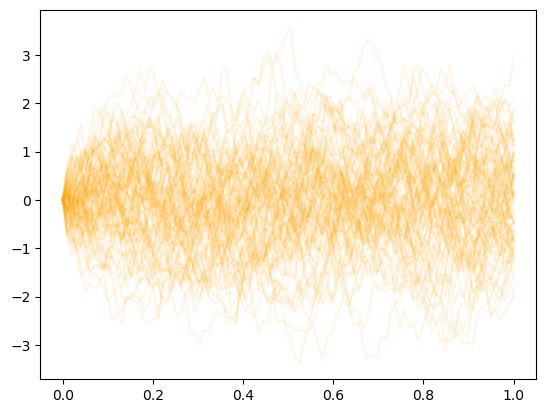

In [4]:
for signal_path in signals[:100]:
    plt.plot(*signal_path, "orange", alpha=0.1)
plt.show()

In [5]:
signature_depth = 4
model = create_generative_net(2, key=model_key)

optim = optax.adam(learning_rate=1e-3)
opt_state = optim.init(eqx.filter(model, eqx.is_array))

In [6]:
@eqx.filter_jit
def batch_normalize(batch_generator, batch_data):
    return jax.vmap(
        lambda _batch: normalize_signature(
            batch_generator(_batch),
            signature_depth,
        )
    )(batch_data)

In [7]:
signature_transform = SignatureTransform(signature_depth)
normalized_signal_sigs = batch_normalize(
    signature_transform, signals.transpose(0, 2, 1)
)

In [8]:
@eqx.filter_jit
def predict(model_to_predict, path):
    path = model_to_predict(path).squeeze()
    timeline = jnp.linspace(0, 1, path.shape[0] + 1)
    path = jnp.stack([timeline, jnp.concatenate([jnp.array([0]), path])])
    path = path.transpose((1, 0))
    sig = signature_transform(path)

    return sig

In [9]:
@eqx.filter_value_and_grad
def loss(model_to_train, paths):
    @eqx.filter_jit
    def mul_mean(sigs1, sigs2):
        return jnp.mean(jnp.matmul(sigs1, sigs2.transpose()))

    generated_sigs = batch_normalize(
        lambda path: predict(
            model_to_train,
            path,
        ),
        paths,
    )

    t1 = mul_mean(normalized_signal_sigs, normalized_signal_sigs)
    t2 = mul_mean(normalized_signal_sigs, generated_sigs)
    t3 = mul_mean(generated_sigs, generated_sigs)

    return jnp.log(t1 - 2 * t2 + t3)

In [10]:
@eqx.filter_jit
def make_step(model_to_train, paths, optimizer_state):
    loss_item, grads = loss(model_to_train, paths)
    updates, optimizer_state = optim.update(grads, optimizer_state)
    model_to_train = eqx.apply_updates(model_to_train, updates)
    return loss_item, model_to_train, optimizer_state

In [11]:
epochs = 500

for step in range(epochs):
    loss_val, model, opt_state = make_step(
        model, train_dataset.transpose(0, 2, 1), opt_state
    )
    if step % 10 == 0:
        print(f"step={step} \t loss={loss_val}")

step=0 	 loss=0.537057638168335
step=10 	 loss=0.5336098074913025
step=20 	 loss=0.5299004316329956
step=30 	 loss=0.5259228944778442
step=40 	 loss=0.5216835141181946
step=50 	 loss=0.5172041654586792
step=60 	 loss=0.5125133991241455
step=70 	 loss=0.5076474547386169
step=80 	 loss=0.5026389360427856
step=90 	 loss=0.4975075125694275
step=100 	 loss=0.49223387241363525
step=110 	 loss=0.4867269694805145
step=120 	 loss=0.48083654046058655
step=130 	 loss=0.4742395579814911
step=140 	 loss=0.4664434492588043
step=150 	 loss=0.45649340748786926
step=160 	 loss=0.44251900911331177
step=170 	 loss=0.4200792610645294
step=180 	 loss=0.37626752257347107
step=190 	 loss=0.275557279586792
step=200 	 loss=0.08368643373250961
step=210 	 loss=0.03819701448082924
step=220 	 loss=-0.026785194873809814
step=230 	 loss=-0.08592521399259567
step=240 	 loss=-0.14778612554073334
step=250 	 loss=-0.22056517004966736
step=260 	 loss=-0.30359190702438354
step=270 	 loss=-0.4017660915851593
step=280 	 los

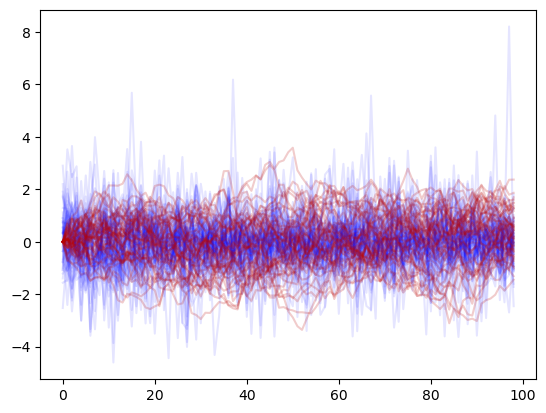

In [12]:
eval_predicted = jax.vmap(lambda datum: model(datum))(
    eval_dataset.transpose(0, 2, 1)
).transpose(0, 2, 1)

plt.plot(eval_predicted[50:100, 0, :99].T, "b", alpha=0.1)
plt.plot(signals[50:100, 1, :99].T, "#ba0404", alpha=0.2)
plt.show()